# Portugal 2012 Bank Marketing Campaign Objective Public Classification Prediction

## 1. Import the initial dependencies

In [376]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, recall_score
import matplotlib.pyplot as plt

## 2. Data Overview

In [377]:
df_bank = pd.read_csv("bank_data_marketing.csv", delimiter = ";")
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


A first look into the dataset, we can see that column contact its irrelevant for the analysis and the future prediction. Let's explore more about the data

### 2.1 Data Overview

#### 2.1.1 Data inspection (nan, null and unknown values)
Using isna() together with sum() method we can note that the dataframe doesnt have any NaN or null values, but it has "unknown" values in some columns. However, poutcome column its a result totally independent from the output variable y, so we wont take it in count, we can proceed the same way with the column contact

In [378]:
df_bank.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [379]:
df_bank.drop(columns=["poutcome", "contact", "day", "month", "pdays", "duration", "previous"], inplace=True)

In [380]:
df_bank

,age,job,marital,education,default,balance,housing,loan,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,1,no
1,44,technician,single,secondary,no,29,yes,no,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,1,no
4,33,unknown,single,unknown,no,1,no,no,1,no
...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,3,yes
45207,71,retired,divorced,primary,no,1729,no,no,2,yes
45208,72,retired,married,secondary,no,5715,no,no,5,yes
45209,57,blue-collar,married,secondary,no,668,no,no,4,no


In [381]:
df_bank.shape

(45211, 10)

In [382]:
(df_bank=="unknown").sum()

age             0
job           288
marital         0
education    1857
default         0
balance         0
housing         0
loan            0
campaign        0
y               0
dtype: int64

Searchig for unknown values in the columns leads to the following result, 288 unknown values for job and 1857 values for education. Both columns can impact on the output prediction, so we need to clear these unknown values, in the worst of the cases we are eliminating 288 + 1857 rows.

In [383]:
df_bank =  df_bank.loc[~df_bank.isin(["unknown"]).any(axis=1)]

In [384]:
df_bank

,age,job,marital,education,default,balance,housing,loan,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,1,no
1,44,technician,single,secondary,no,29,yes,no,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,1,no
5,35,management,married,tertiary,no,231,yes,no,1,no
6,28,management,single,tertiary,no,447,yes,yes,1,no
...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,3,yes
45207,71,retired,divorced,primary,no,1729,no,no,2,yes
45208,72,retired,married,secondary,no,5715,no,no,5,yes
45209,57,blue-collar,married,secondary,no,668,no,no,4,no


### 2.1.2 Data Analysis
When searching for patterns in the data, we must first explore the different columns (types of structured data and their values). First we must identify the type of data that we have in each column (and if its relevant), e.g. we sepparate the categorigal variables from the numeric data, this will help us determine what kind of correlation analysis we can perform with the output data.

#### 2.1.2.1 Categorical Data Analysis

Let us take a look at the categorical variables. The dataset columns that we want to analyze are from two tipes, for example columns job, marital, education can be considered as categorical variables because they have different unique values to specify the status of a client such as, in the case of education, primary, secondary and tertiary education which can be treated as a jerarchy variable. In case of the variables loan, housing and default the data shows that we can treat then as boolean variables because they are represented by strings yes and no or in other cases such as false or true values.

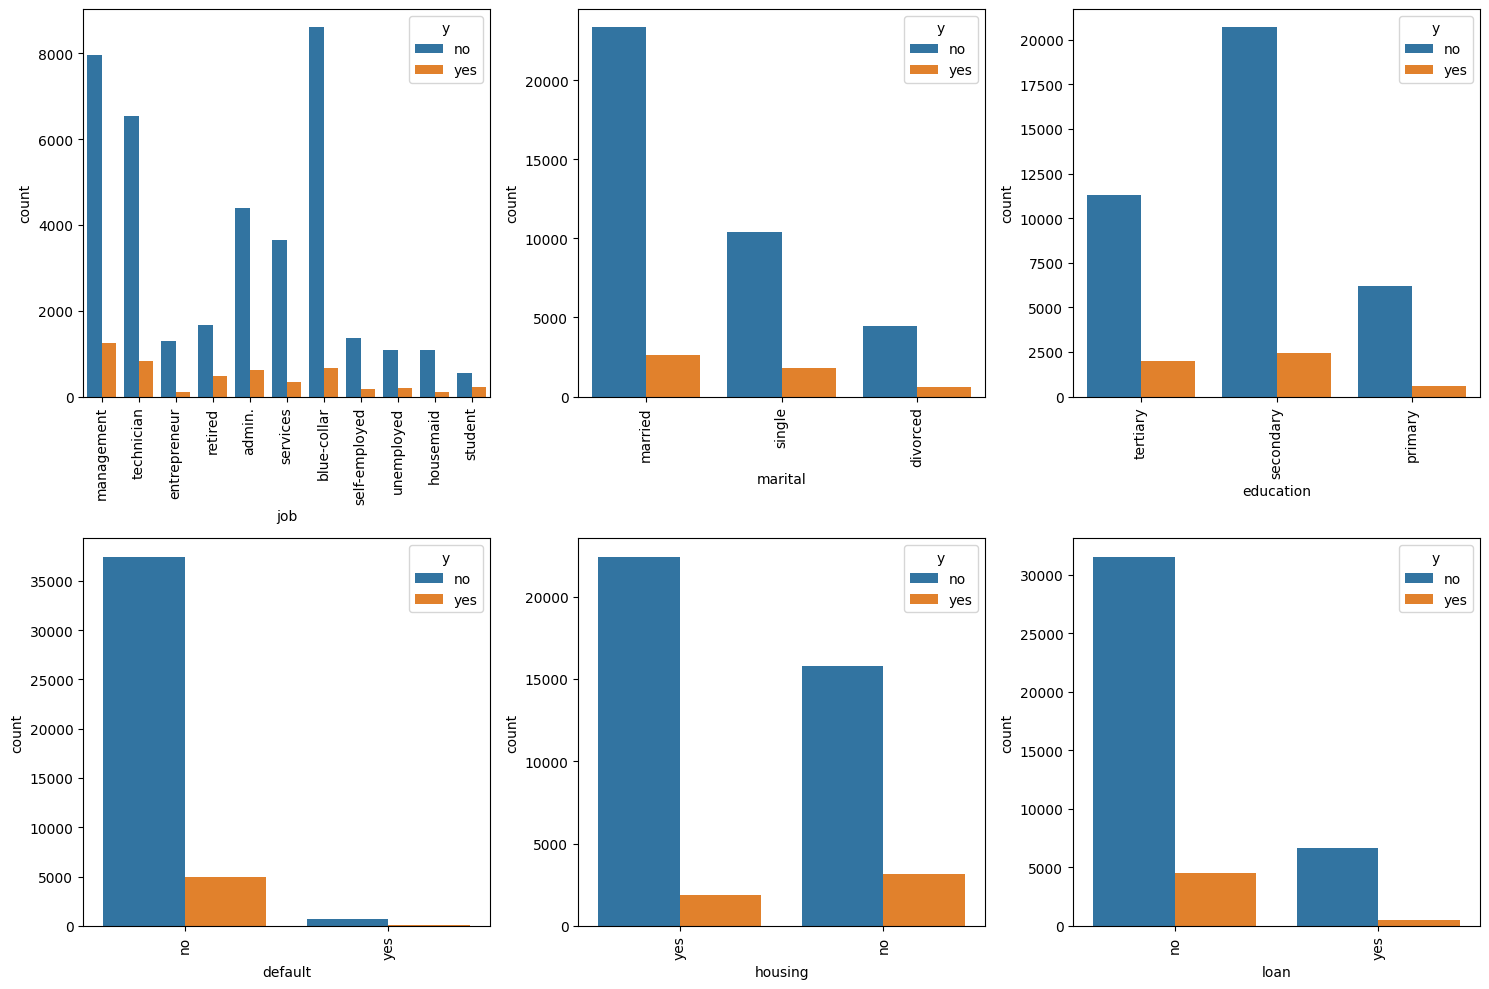

In [385]:
categorical_inputs = ["job", "marital", "education", "default", "housing", "loan"]
fig, axs = plt.subplots(nrows=2, ncols = 3, figsize=(15,10))
axs = axs.flatten()
for i, var in enumerate(categorical_inputs):
    sns.countplot(x=var, hue='y', data=df_bank, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
fig.tight_layout()

plt.show()

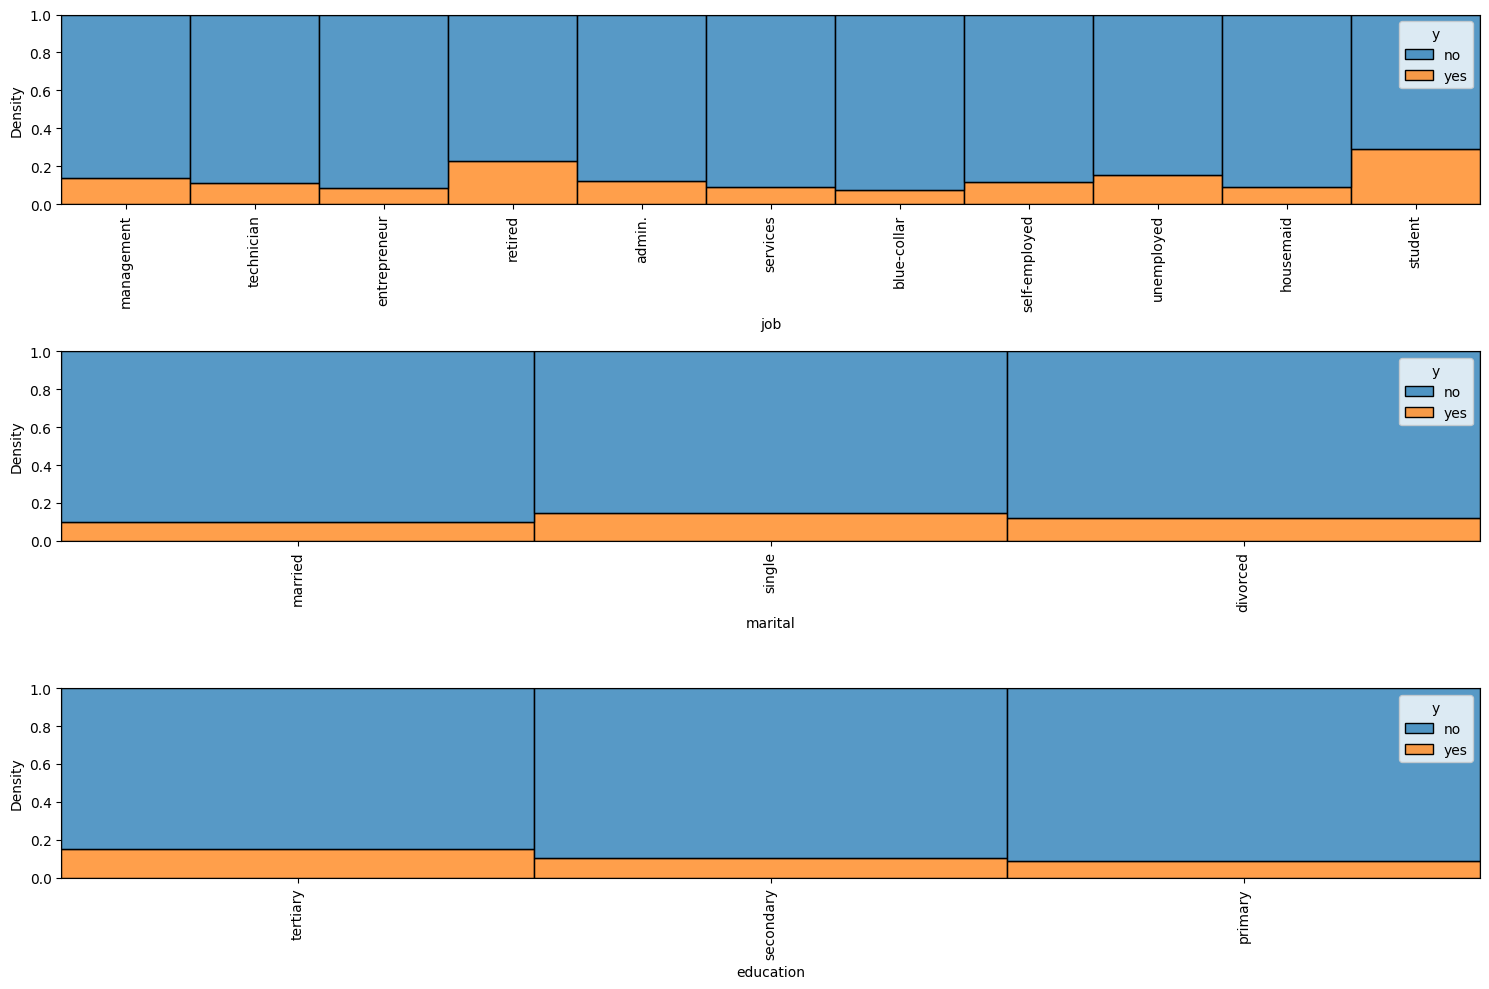

In [386]:
import warnings
warnings.filterwarnings("ignore")
categorical_labels = ["job", "marital", "education"]

fig_, axs_ = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
axs_ = axs_.flatten()

for i, var in enumerate(categorical_labels):
  sns.histplot(x=var, hue="y", data=df_bank, ax=axs_[i], multiple="fill", kde=False, element="bars", fill=True, stat="density")
  xticks = range(len(df_bank[var].unique()))
  axs_[i].set_xticks(xticks)
  axs_[i].set_xticklabels(df_bank[var].unique(), rotation=90)
  axs_[i].set_xlabel(var)

fig_.tight_layout()
plt.show()

#### 2.1.1.2 Numerical Data Analysis
In the case of numerical variables such as balance, age, campaign we can recognize a group of values, for each one, that can be classified as outliers and data that doesnt vary significantly between the average value and their interquartile range. To create models that perform well in prediction, outliers should be removed from the dataset.

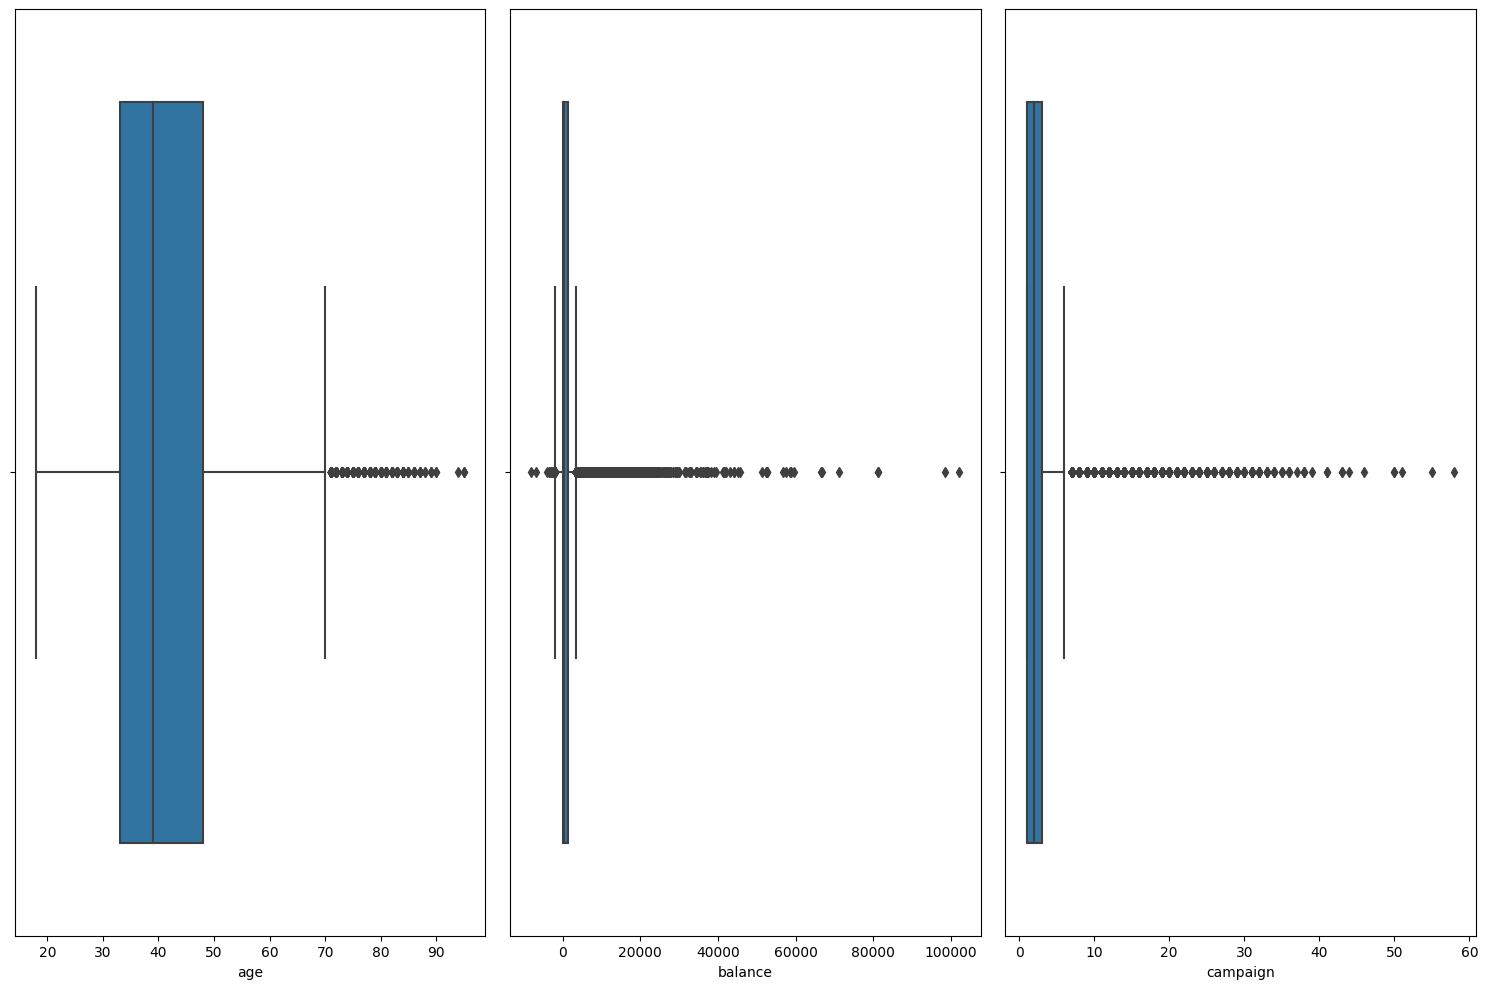

In [387]:
numerical_vars = ["age", "balance", "campaign"]

fig, axs =  plt.subplots(nrows=1, ncols=3, figsize=(15,10))
axs = axs.flatten()

for i, var in enumerate(numerical_vars):
  sns.boxplot(x=var, data=df_bank, ax=axs[i])
fig.tight_layout()
plt.show()

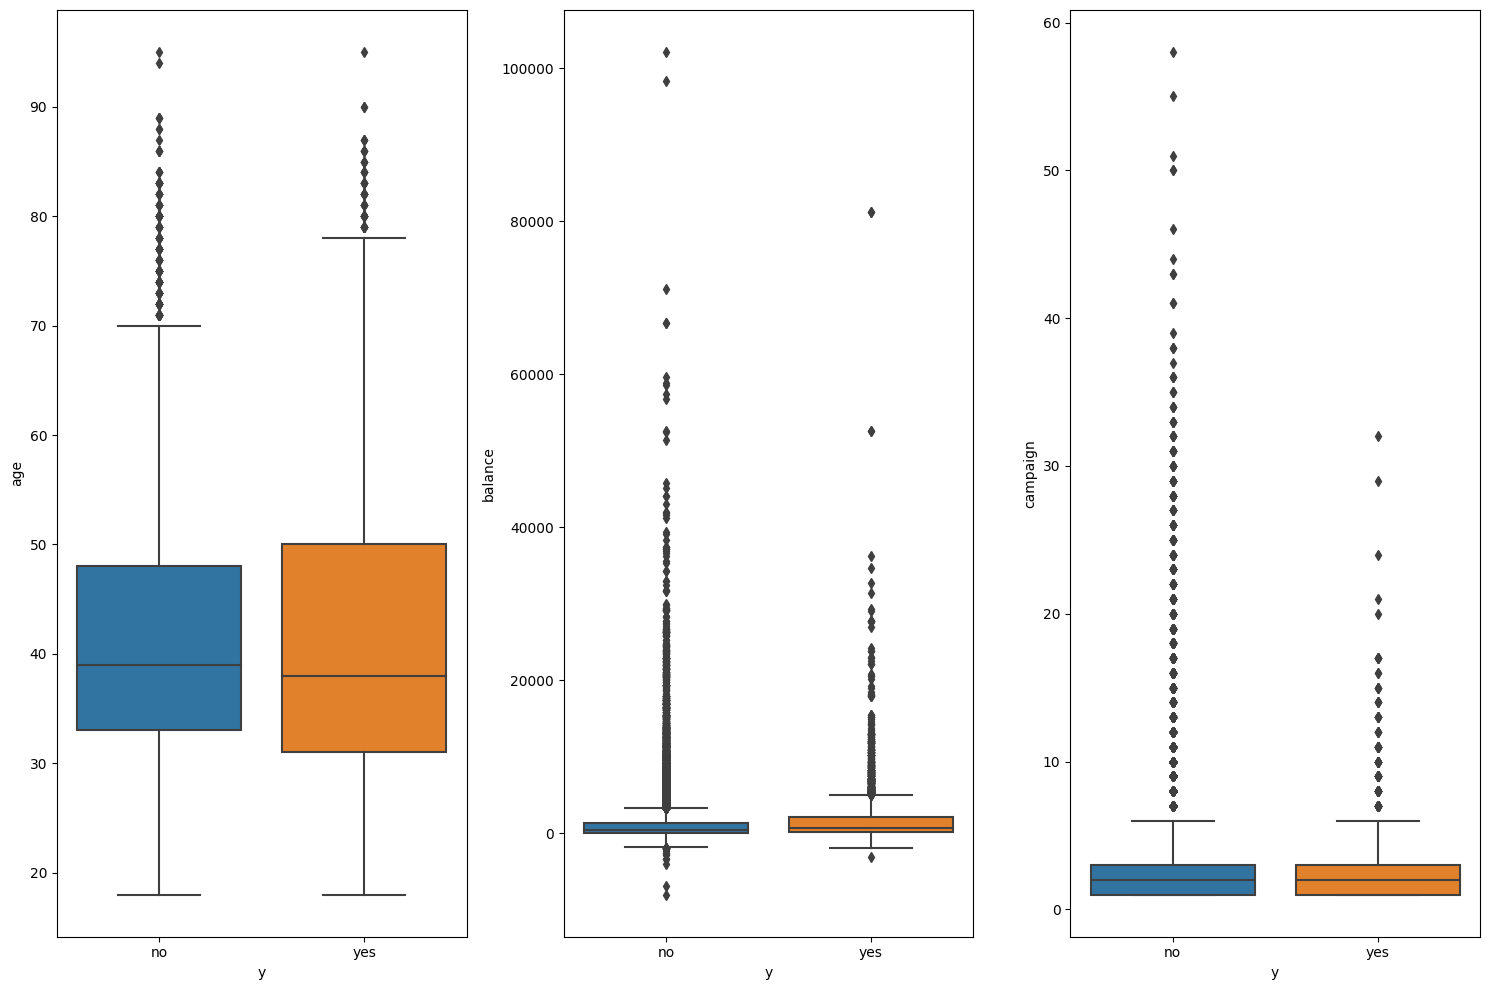

In [388]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
axs = axs.flatten()
for i, var in enumerate(numerical_vars):
  sns.boxplot(y=var, x="y", data=df_bank, ax=axs[i])
fig.tight_layout()
plt.show()

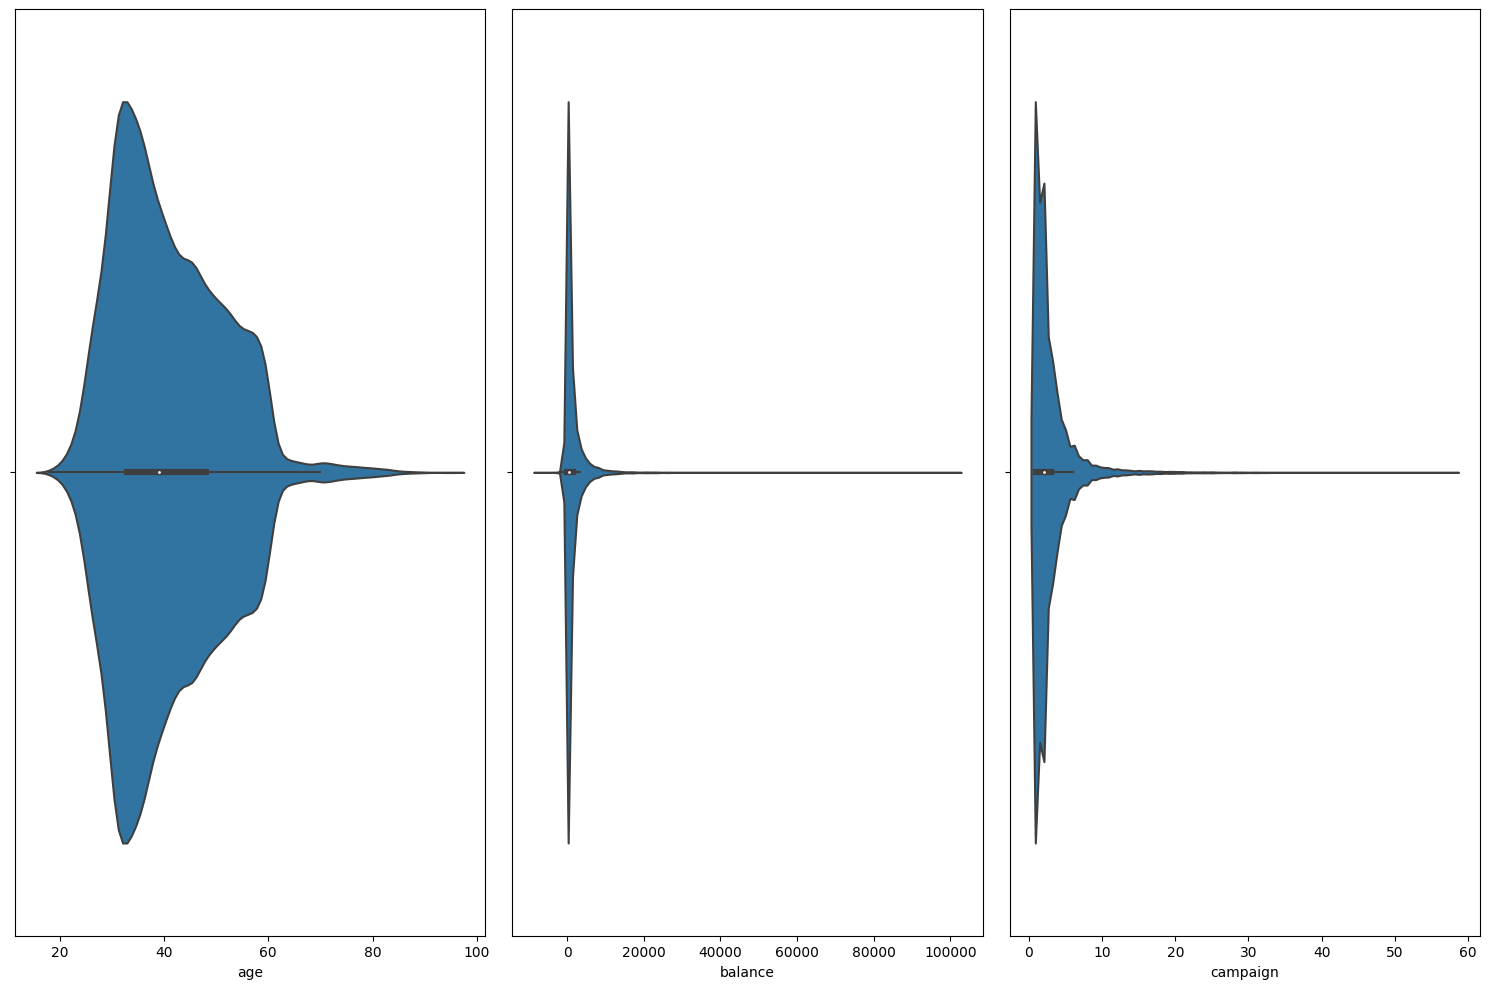

In [389]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
axs = axs.flatten()
for i, var in enumerate(numerical_vars):
  sns.violinplot(x=var, data=df_bank, ax=axs[i])
fig.tight_layout()
plt.show()

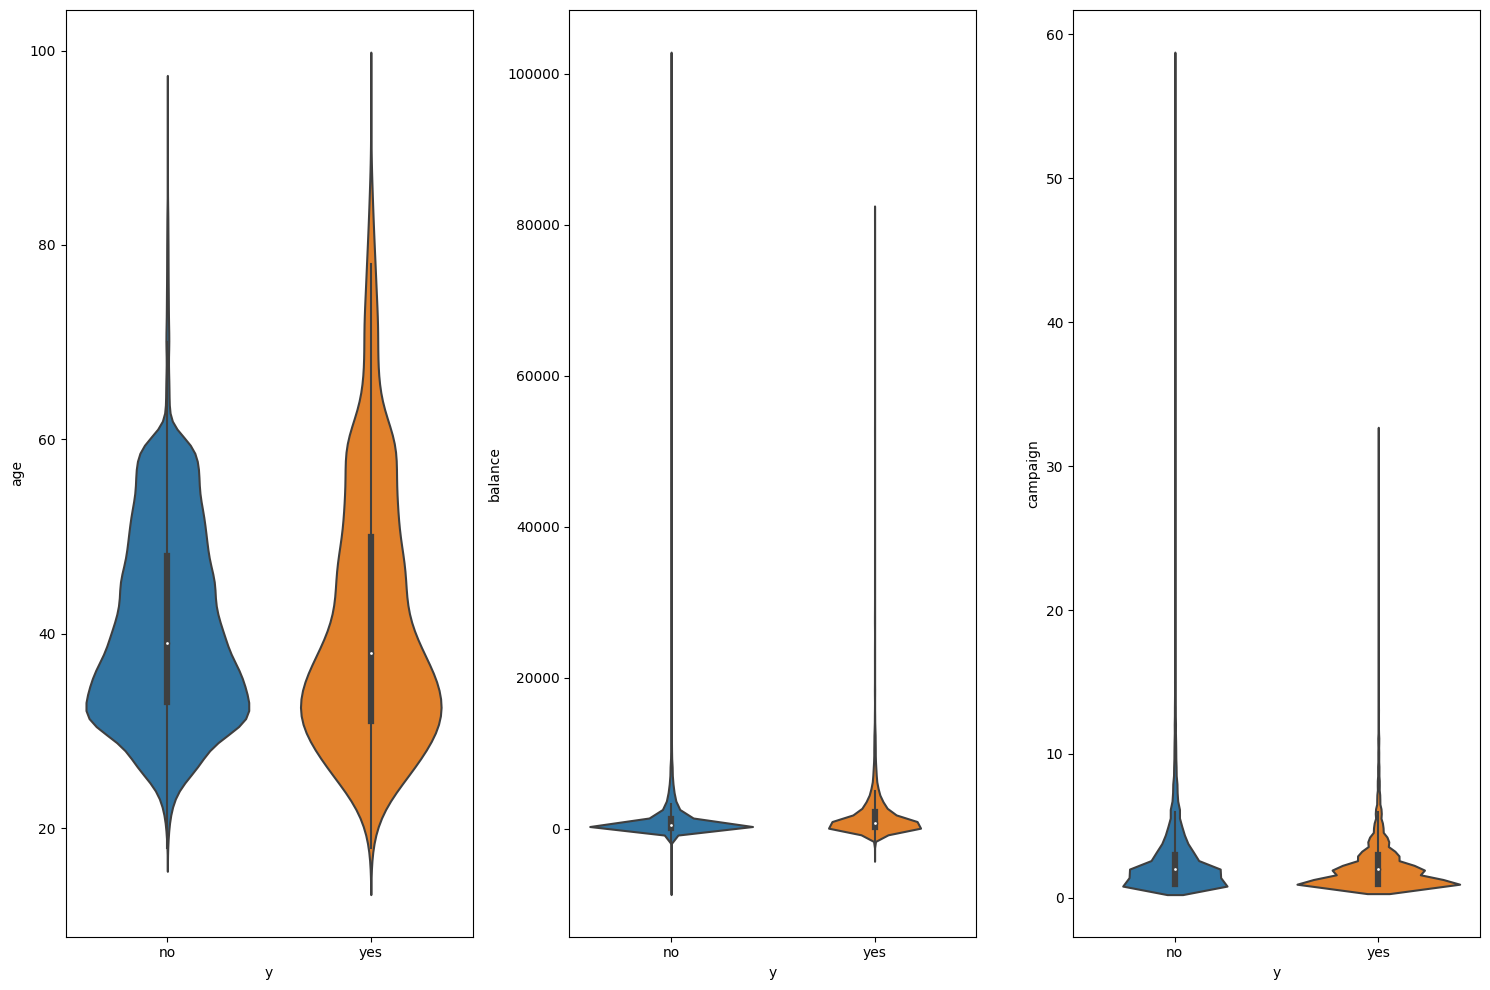

In [390]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
axs = axs.flatten()
for i, var in enumerate(numerical_vars):
  sns.violinplot(y=var, x="y", data=df_bank, ax=axs[i])
fig.tight_layout()
plt.show()

In [391]:
#Creating an auxiliar function to avoid outliers:
def remove_outliers(df, columns):
    df_filtered = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    return df_filtered


In [392]:
df_bank = remove_outliers(df_bank, numerical_vars)
df_bank

,age,job,marital,education,default,balance,housing,loan,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,1,no
1,44,technician,single,secondary,no,29,yes,no,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,1,no
5,35,management,married,tertiary,no,231,yes,no,1,no
6,28,management,single,tertiary,no,447,yes,yes,1,no
...,...,...,...,...,...,...,...,...,...,...
45203,23,student,single,tertiary,no,113,no,no,1,yes
45205,25,technician,single,secondary,no,505,no,yes,2,yes
45206,51,technician,married,tertiary,no,825,no,no,3,yes
45209,57,blue-collar,married,secondary,no,668,no,no,4,no


In [393]:
for col in df_bank.select_dtypes(include=['object']).columns:

    # Print the column name and the unique values
    print(f"{col}: {df_bank[col].unique()}")

job: ['management' 'technician' 'entrepreneur' 'retired' 'admin.' 'services'
 'blue-collar' 'self-employed' 'unemployed' 'housemaid' 'student']
marital: ['married' 'single' 'divorced']
education: ['tertiary' 'secondary' 'primary']
default: ['no' 'yes']
housing: ['yes' 'no']
loan: ['no' 'yes']
y: ['no' 'yes']


## 2.2 Feature Engineering
To perform feature engineering we must first have to identify the columns in which this technique will be applie. In this case we apply it over the columns job, marital and education.
The techniques of feature engineering can be applied in a way that, for example we generate additional columns from the existing ones (pandas dummies), generating columns based on aggregation functions that we get from the data (feature aggregation) or even transforming an entire columns to numerical data in which each value represents a grade of jerarchy (label encoding).

#### 2.2.1 Performing Pandas dummies encoding

In [394]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn import preprocessing

jobs_encoded = pd.get_dummies(df_bank['job'], prefix='job').astype(int)
marital_encoded = pd.get_dummies(df_bank['marital'], prefix='marital').astype(int)
education_encoded = pd.get_dummies(df_bank['education'], prefix='education').astype(int)


# Concatenate the encoded job columns with the original dataframe
df_bank = pd.concat([df_bank, jobs_encoded, marital_encoded, education_encoded], axis=1)

# Drop the original 'jobs' column
df_bank.drop(['job','marital', 'education'], axis=1, inplace=True)


#### 2.2.2. Label Encoding and Feature Aggregation

In [327]:
# label_encoder = preprocessing.LabelEncoder()
    
#     # Fit the encoder to the unique values in the column
# label_encoder.fit(df_bank[col].unique())
    
#     # Transform the column using the encoder
# df_bank['y'] = label_encoder.transform(df_bank['y'])
# jobs_agg = df_bank.groupby('job')['y'].agg(['count', 'mean', 'std']).reset_index()

# # Rename the aggregated columns
# jobs_agg.rename(columns={'count': 'jobs_count', 'mean': 'jobs_mean', 'std': 'jobs_std'}, inplace=True)

# # Merge the aggregated features with the original dataframe
# df_bank = pd.merge(df_bank, jobs_agg, on='job', how='left')
# df_bank
# df_bank.drop('job', inplace=True, axis=1)

In [395]:
from sklearn import preprocessing

# Loop over each column in the DataFrame where dtype is 'object'
for col in df_bank.select_dtypes(include=['object']).columns:
    
    # Initialize a LabelEncoder object
    label_encoder = preprocessing.LabelEncoder()
    
    # Fit the encoder to the unique values in the column
    label_encoder.fit(df_bank[col].unique())
    
    # Transform the column using the encoder
    df_bank[col] = label_encoder.transform(df_bank[col])
    
    # Print the column name and the unique encoded values
    print(f"{col}: {df_bank[col].unique()}")

default: [0 1]
housing: [1 0]
loan: [0 1]
y: [0 1]


## 2.3 Correlation Matrix

<Axes: >

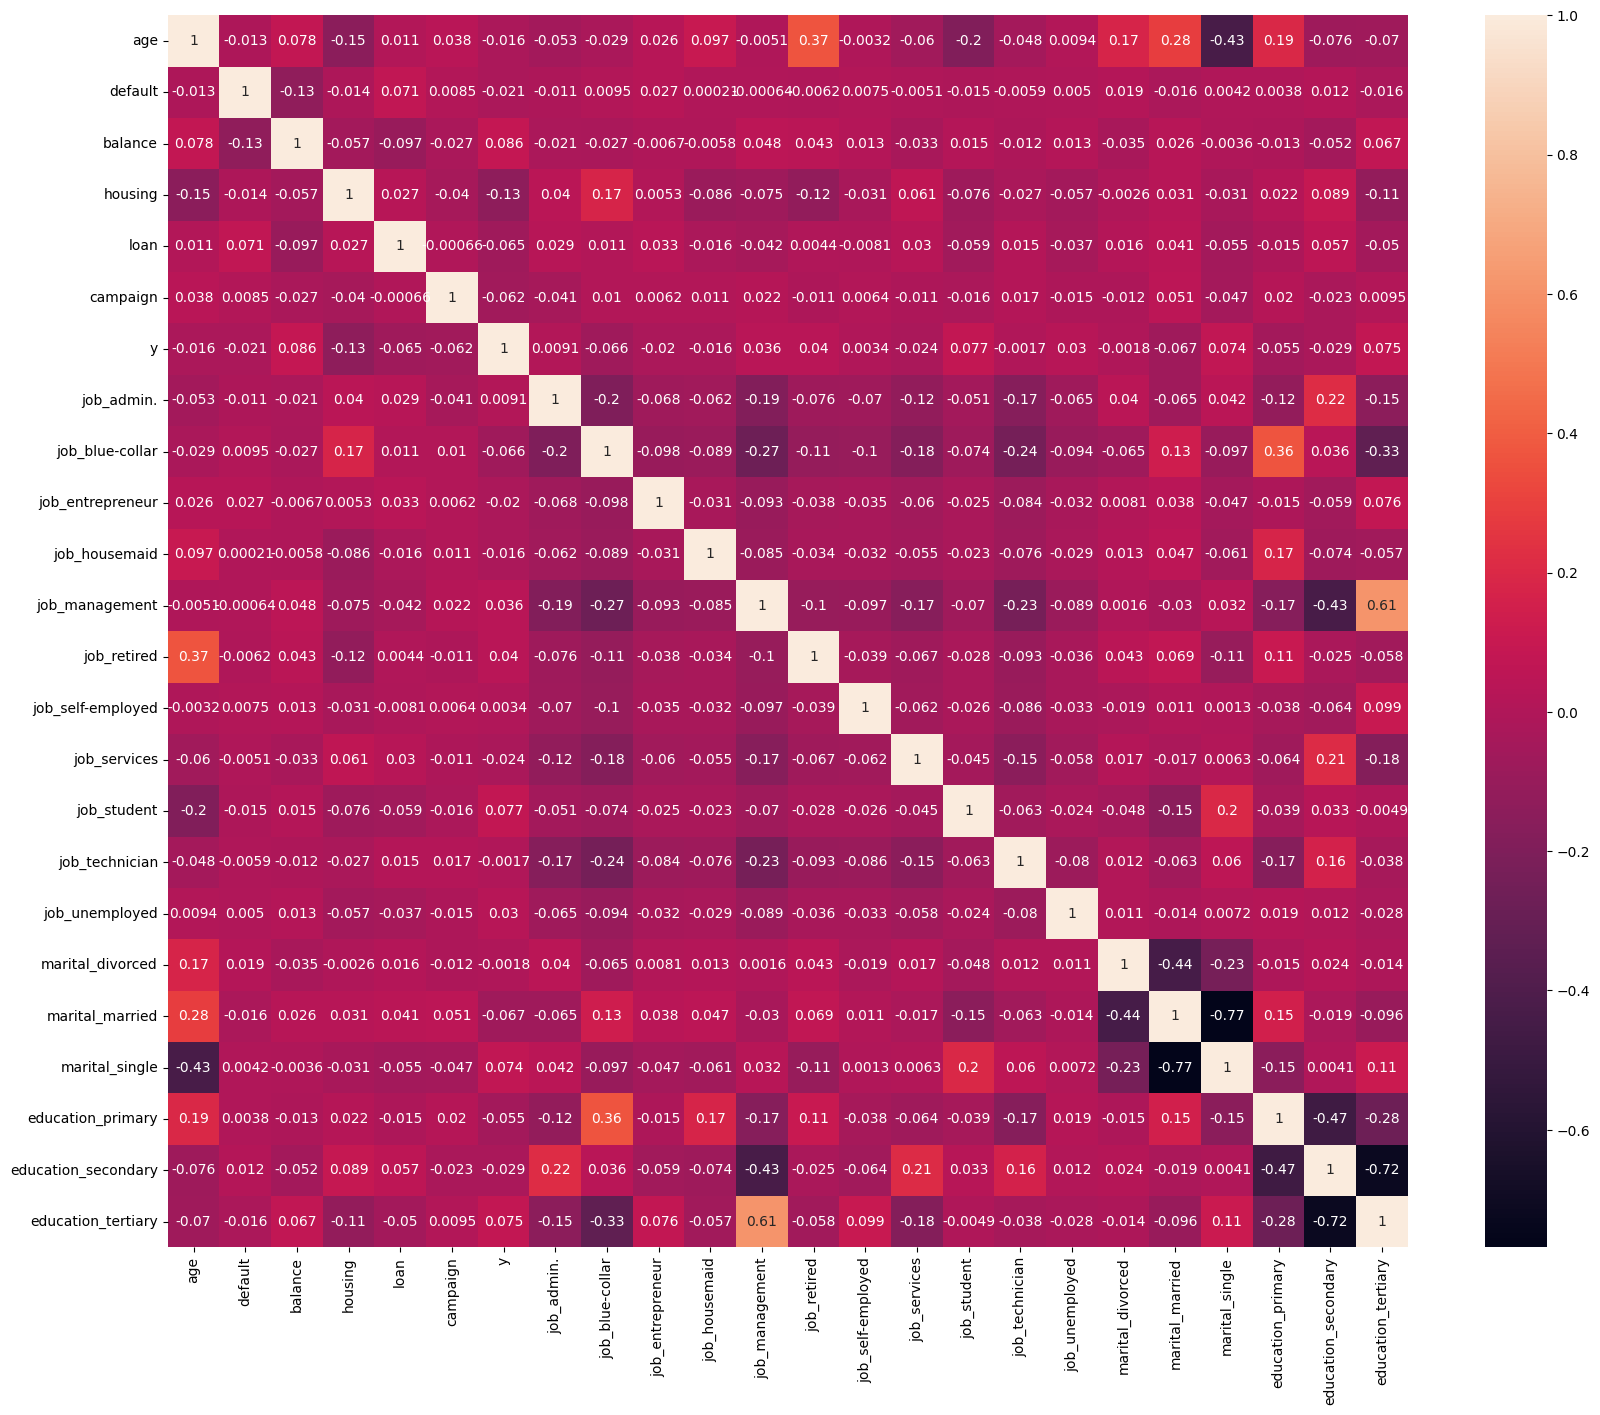

In [396]:
#Correlation Heatmap (print the correlation score each variables)
plt.figure(figsize=(20, 16))
sns.heatmap(df_bank.corr(), fmt='.2g', annot=True)

## 3 Data train-test selection

In [397]:
from sklearn.model_selection import train_test_split

X = df_bank.drop('y', axis=1)
y = df_bank['y']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [398]:
X_test

,age,default,balance,housing,loan,campaign,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
40998,33,0,227,1,1,2,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
43100,26,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
35214,33,0,1646,1,0,2,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
28883,44,0,780,1,0,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
29518,27,0,924,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25953,41,0,2004,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
25777,53,0,2818,1,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
23413,37,0,298,0,0,5,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
26152,35,0,867,1,0,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


## 4. Model Selection

### 4.1 Decison Tree Classifier

#### 4.1.1 Decision Tree Classifier Hyperparameter Optimization

In [399]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

decision_tree = DecisionTreeClassifier(class_weight="balanced")
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4],
    'random_state': [0, 42]
}
# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(decision_tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)


{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0}


#### 4.1.2. Evaluating metrics and performance

In [400]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

Accuracy Score : 72.69 %


In [401]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

F-1 Score :  0.7268654626907461
Precision Score :  0.7268654626907461
Recall Score :  0.7268654626907461
Jaccard Score :  0.5709258851990323
Log Loss :  9.84476659137163


In [402]:
grid_search.best_params_

{'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 0}

In [403]:
dtree = DecisionTreeClassifier(**grid_search.best_params_)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

#### 4.1.3. Results Analysis

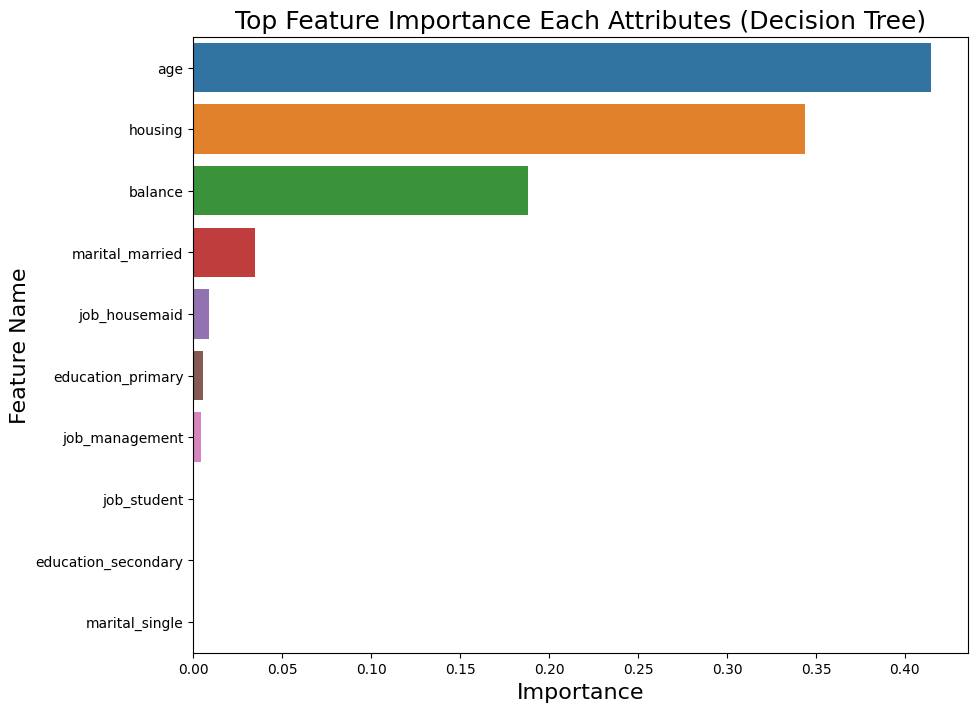

In [404]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": dtree.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top Feature Importance Each Attributes (Decision Tree)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

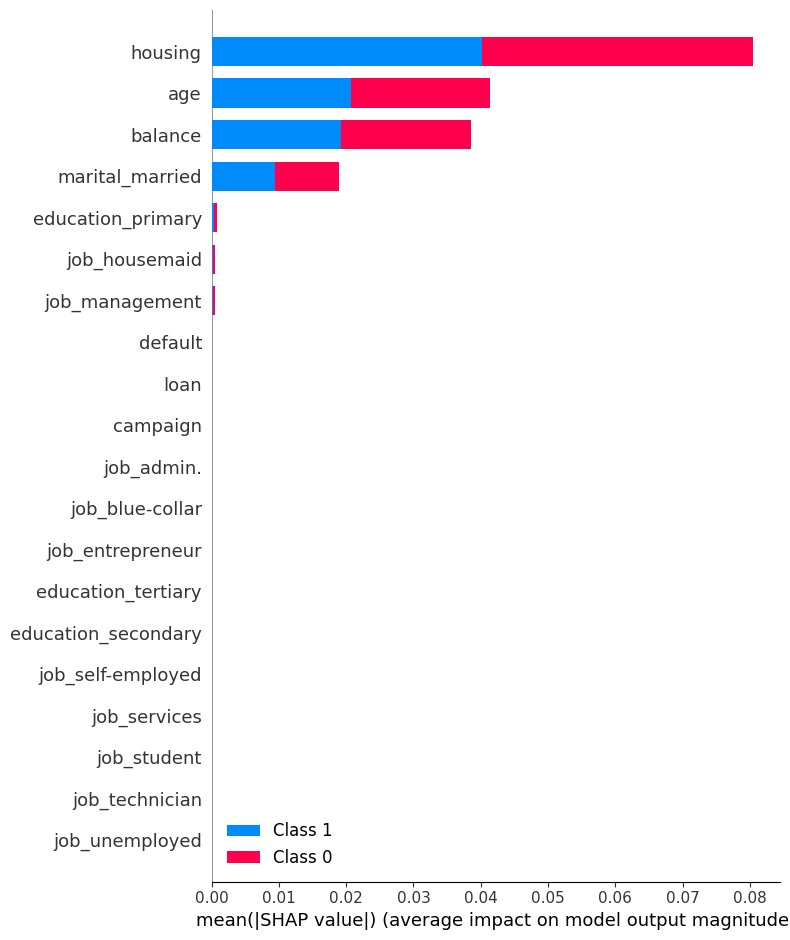

In [405]:
import shap
explainer = shap.TreeExplainer(dtree)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Text(0.5, 1.0, 'Accuracy Score for Decision Tree: 0.8842223155536889')

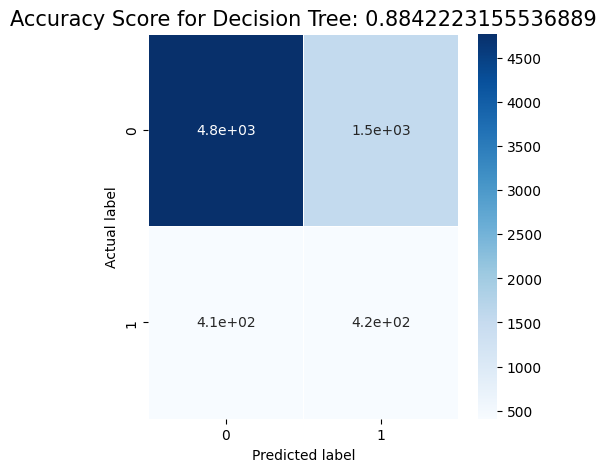

In [406]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree: {0}'.format(dtree.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

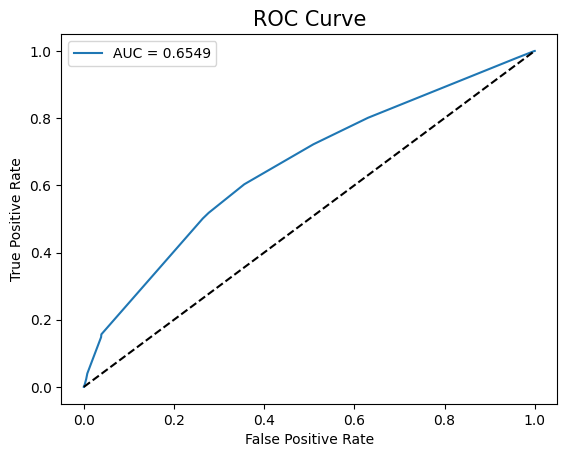

In [407]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = dtree.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

### 4.2 Random Forest Classifier Model

#### 4.2.1. Random Forest Classifier Hyperparameter Optimization

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(class_weight='balanced')
param_grid = {
    'n_estimators': [200, 350,400],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [0, 42]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': None, 'max_features': None, 'n_estimators': 350, 'random_state': 0}


In [123]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(**grid_search.best_params_, class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=None,
                       n_estimators=350, random_state=0)

#### 4.2.2. Evaluating metrics and performance

In [124]:
y_pred = rfc.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

Accuracy Score : 87.99 %


In [125]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

F-1 Score :  0.8798824023519528
Precision Score :  0.8798824023519529
Recall Score :  0.8798824023519529
Jaccard Score :  0.7855268091488564
Log Loss :  4.329477055559641


#### 4.2.3. Results Analysis

Text(0.5, 1.0, 'Accuracy Score for Random Forest: 0.8798824023519529')

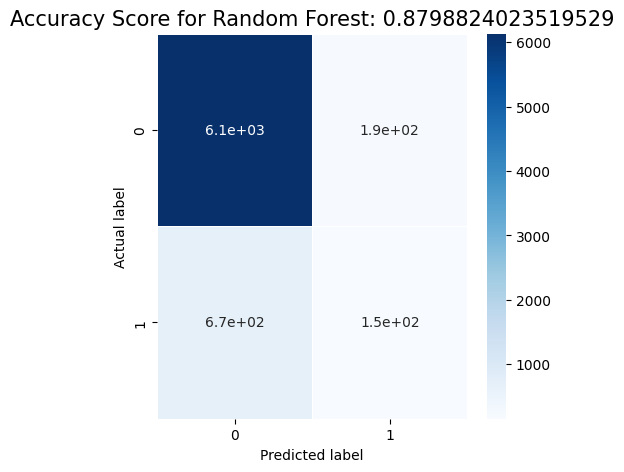

In [126]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Random Forest: {0}'.format(rfc.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

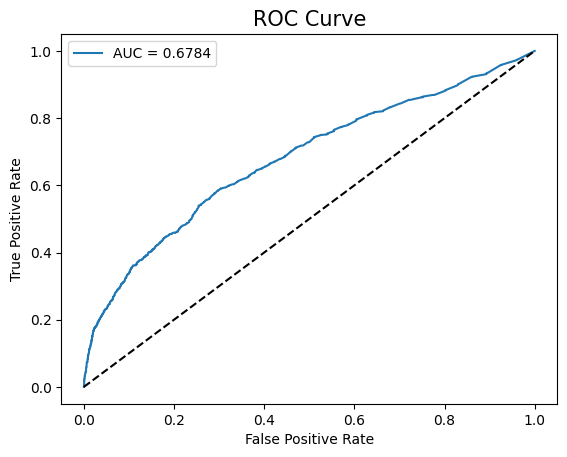

In [127]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = rfc.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

### 4.3 Logistic Classification  Model 

#### 4.3.1 Logistic Classification Model Hyperparameter Optimization

In [408]:
from sklearn.linear_model import LogisticRegression
log_regg = LogisticRegression()
param_grid = {
    'C': [0.1,0.01, 0.3, 1, 10], 'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(log_regg, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'C': 0.1, 'penalty': 'l2'}


In [409]:
log_regg = LogisticRegression(**grid_search.best_params_)
log_regg.fit(X_train, y_train)
y_pred = log_regg.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

Accuracy Score : 88.48 %


#### 4.3.2 Evaluating metrics and performance

In [410]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

F-1 Score :  0.8847823043539129
Precision Score :  0.8847823043539129
Recall Score :  0.8847823043539129
Jaccard Score :  0.7933718302786844
Log Loss :  4.152866686160356


#### 4.3.3 Results Analysis

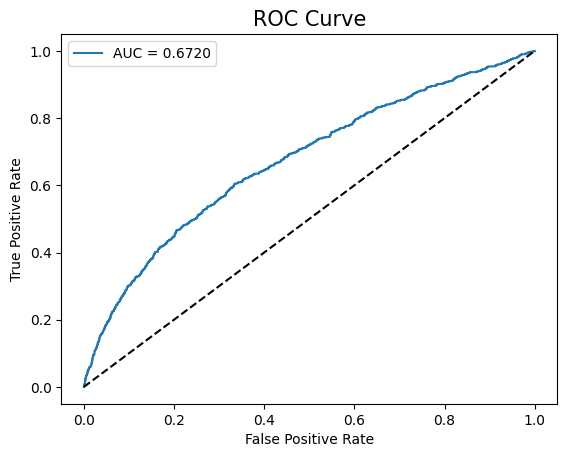

In [411]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = log_regg.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

Text(0.5, 1.0, 'Accuracy Score for Logistic Classifier: 0.8847823043539129')

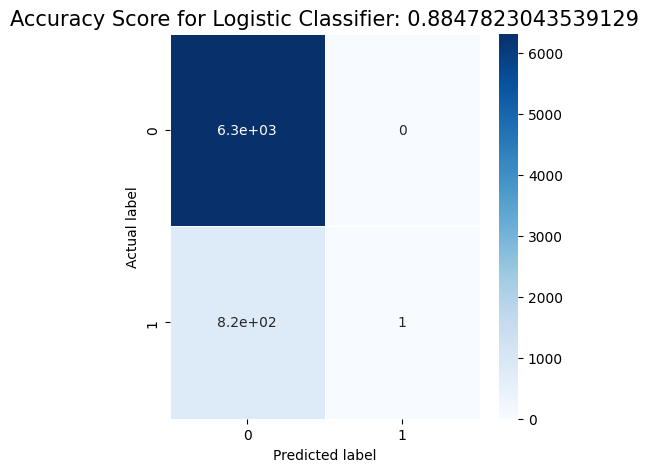

In [412]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Logistic Classifier: {0}'.format(log_regg.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

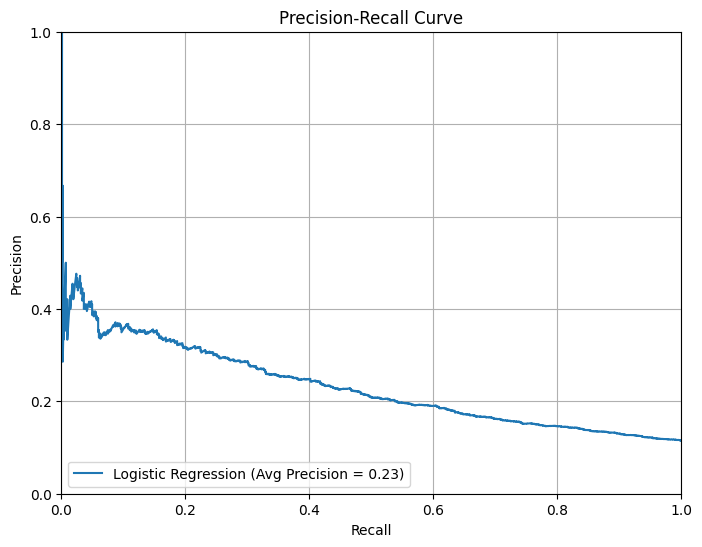

In [413]:
from sklearn.metrics import precision_recall_curve, average_precision_score
y_prob = log_regg.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Logistic Regression (Avg Precision = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.show()


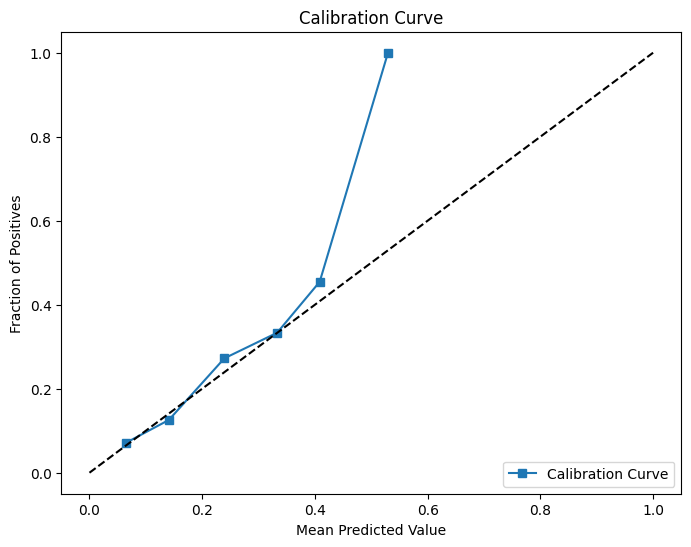

In [414]:
from sklearn.calibration import calibration_curve
y_prob = log_regg.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Calibration Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='lower right')
plt.show()

In [415]:
from sklearn.metrics import classification_report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6319
           1       1.00      0.00      0.00       824

    accuracy                           0.88      7143
   macro avg       0.94      0.50      0.47      7143
weighted avg       0.90      0.88      0.83      7143



###  4.4 XGBoost Classifier Model

####  4.4.1 XGBoost Classifier Model Hyperparameter Optimization

In [416]:
from xgboost import XGBClassifier
import xgboost as xgb

xgb_class = XGBClassifier()
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [175,250,350],
    #subsample': [0.6, 0.8, 1.0],
    #'colsample_bytree': [0.8, 0.9, 1.0]
}
grid_search = GridSearchCV(xgb_class, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 175}


In [417]:
xgb_class = XGBClassifier(**grid_search.best_params_)
xgb_class.fit(X_train, y_train)
y_pred = xgb_class.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

Accuracy Score : 88.42 %


In [418]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

F-1 Score :  0.8842223155536889
Precision Score :  0.8842223155536889
Recall Score :  0.8842223155536889
Jaccard Score :  0.7924717691342534
Log Loss :  4.173050728377417


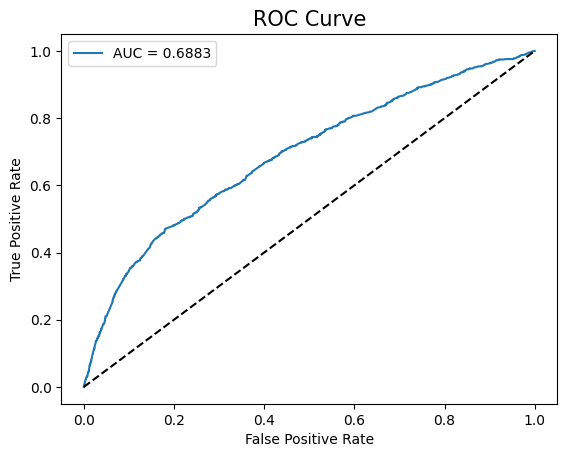

In [419]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = xgb_class.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

Text(0.5, 1.0, 'Accuracy Score for XGBoost Classifier: 0.8842223155536889')

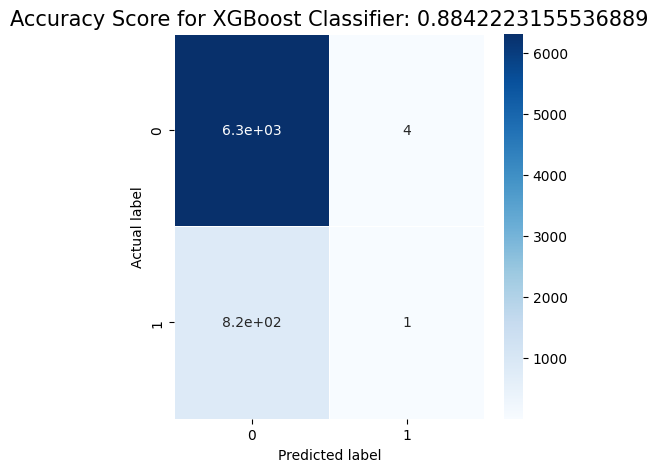

In [420]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for XGBoost Classifier: {0}'.format(xgb_class.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

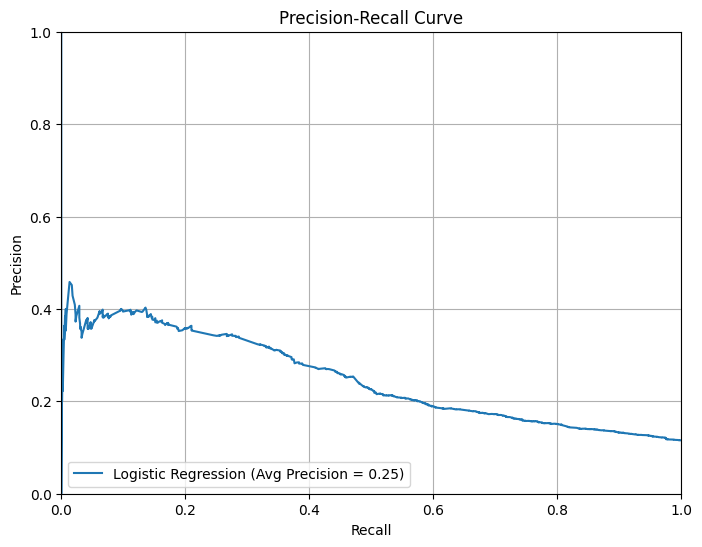

In [421]:
from sklearn.metrics import precision_recall_curve, average_precision_score
y_prob = xgb_class.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Logistic Regression (Avg Precision = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.show()


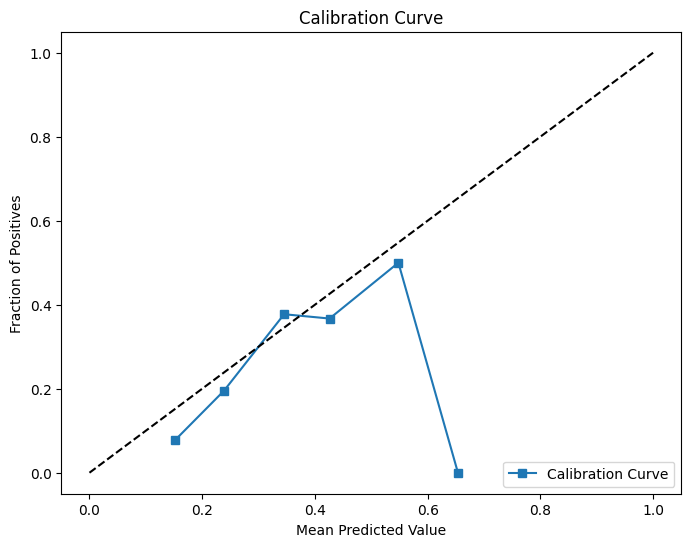

In [422]:
from sklearn.calibration import calibration_curve
y_prob = xgb_class.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Calibration Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='lower right')
plt.show()

In [423]:
from sklearn.metrics import classification_report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6319
           1       0.20      0.00      0.00       824

    accuracy                           0.88      7143
   macro avg       0.54      0.50      0.47      7143
weighted avg       0.81      0.88      0.83      7143



According to results, the model that performs better is the XGBoost Classifier model showing a better accuracy and evaluation in different metrics compared to the other models. However, XGBoost or any of the other models could be improved with other type of feature engineering, these results show the better performance for pandas dummies encoding, other ways to explore the optimization of the model should be try using scalers in the column balance or other techniques of feature engineering.